# PyCS Tutorial

In this notebook we work through the `PyCS` "demo1" tutorial, to show how the `PyCS` package enables the estimation of a lens time delay from example light curve data. The original tutorial is in the form of a set of 6 scripts, that can be viewed on the `PyCS` website [here](http://pycs.readthedocs.io/en/latest/tutorial/demo1.html). The demo1 code itself can be browsed in the `PyCS` GitHub repository [here](https://github.com/COSMOGRAIL/PyCS/tree/master/demo/demo1).

## 1. Obtaining PyCS and its Sample Data 

The "demo1" tutorial uses a 4-image light curve dataset that comes with the `PyCS` repository. Let's download this and use `PyCS` to analyze it. If you haven't yet followed the [`SLTimer` installation instructions](https://github.com/DarkEnergyScienceCollaboration/SLTimer/blob/master/INSTALL.md) you should do that before attempting to `import pycs`. 

In [1]:
import os, urllib
from __future__ import print_function
import pycs
%matplotlib inline

We need to grab `rdbfile` (the demo1 dataset) from `webdir` (the appropriate `PyCS` GitHub folder). We only need to download `rdbfile` if it doesn't already exist.

In [2]:
webdir = 'https://raw.githubusercontent.com/COSMOGRAIL/PyCS/master/demo/demo1/data/'
rdbfile = 'trialcurves.txt'
    
url = os.path.join(webdir, rdbfile)
if not os.path.isfile(rdbfile):
    urllib.urlretrieve(url, rdbfile)
    
!wc -l $rdbfile

     194 trialcurves.txt


## 2. Displaying the Light Curve Data

First lets read in the data from the rdbfile, in this case from a simple text file with a one-line header. (Other formats are supported as well.)

In [3]:
lcs = [
        pycs.gen.lc.rdbimport(rdbfile, 'A', 'mag_A', 'magerr_A', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'B', 'mag_B', 'magerr_B', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'C', 'mag_C', 'magerr_C', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'D', 'mag_D', 'magerr_D', "Trial")
]

Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/A] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/B] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/C] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/D] with 192 points imported (0 of them masked).


We'll want to plot each light curve with a different color:

In [4]:
pycs.gen.mrg.colourise(lcs) 

If we shift the data by the "true" time shifts, the light curves will line up nicely for display purposes. We will infer the time delays from the data later in this notebook.

In [5]:
lcs[1].shifttime(-5.0)
lcs[2].shifttime(-20.0)
lcs[3].shifttime(-70.0)

Now to display our plot! 

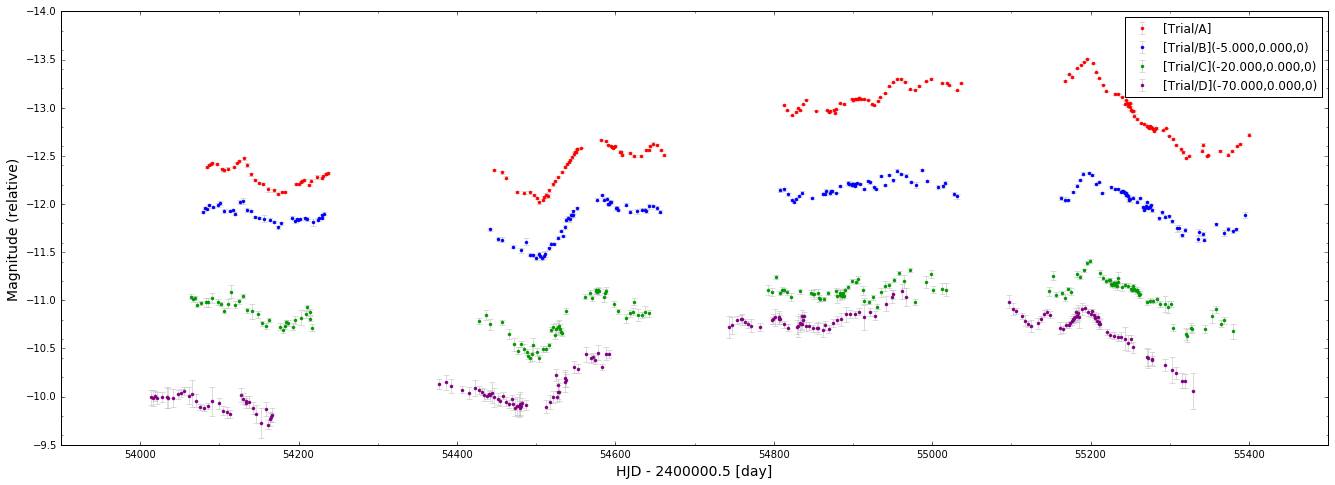

In [6]:
pycs.gen.lc.display(lcs, figsize=(20, 7), jdrange=(53900, 55500))

To save this figure to a file: 

In [7]:
pycs.gen.lc.display(lcs, filename="fig_trialcurves_true-shifted.pdf")

Plot written to fig_trialcurves_true-shifted.pdf


It's useful to store the lightcurve objects in a pickle for easy re-starting - here's the function for doing that:

In [8]:
pycs.gen.util.writepickle(lcs, "trialcurves_true-shifted.pkl")

Wrote trialcurves_true-shifted.pkl


In further scripts, you can now import the data by reading this file. 

In [9]:
lcs = pycs.gen.util.readpickle("trialcurves_true-shifted.pkl")

Read trialcurves_true-shifted.pkl


We will now undo these shifts, and from now on we will "forget" about the true delays. 

In [10]:
for l in lcs:
        l.resetshifts()

You can do a variety of things with this file to find out more information. For example, the `longinfo()` method will provide you with the number of points, gap length, shifts, median, mean, maximum, minimum, and the colour it is plotted in.  

In [11]:
for l in lcs: print(l.longinfo())

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
	[Trial/A]
192 points (total), 0 of which are masked
4 seasons (gap: >60), gap length : 164.0 +/- 33.8 days
Sampling : median 4.0, mean 4.4, max 25.1, min 0.83 days
Shifts : (0.00000,0.00000,0.00) [days, mag, flux]
Colour : red
Common properties : 
   All properties : 
Comments :
   Imported from trialcurves.txt, columns (1, 2, 3)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
	[Trial/B]
192 points (total), 0 of which are masked
4 seasons (gap: >60), gap length : 164.0 +/- 33.8 days
Sampling : median 4.0, mean 4.4, max 25.1, min 0.83 days
Shifts : (0.00000,0.00000,0.00) [days, mag, flux]
Colour : blue
Common properties : 
   All properties : 
Comments :
   Imported from trialcurves.txt, columns (1, 4, 5)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
	[Trial/C]
192 points (total

Another thing we can do is export the data into a text file called "out_trialcurves.txt". In this case, since we have not altered the original data, this file will contain the same information as trialcurves.txt.

In [12]:
pycs.gen.util.multilcsexport(lcs, "out_trialcurves.txt", separator="\t", verbose=True, properties=None)

[Trial/A]
[Trial/B]
[Trial/C]
[Trial/D]
Wrote the lightcurves into out_trialcurves.txt


## 3. Fitting the Light Curves with a Free-Knot Spline Model

Let's now fit a spline model to our lightcurve data. At first we'll ignore microlensing and just set up a single spline curve to capture the intrinsic AGN variability. Then we'll add in additional curves to model the microlensing, and refine the fit.

## 3.1 Basic Fit

`PyCS` contains library functions for optimizing such a model, but the optimization has to be carried out according to a user-defined schedule. Shown here is a simple attempt to get a multi-purpose schedule for optimizing a free-knot spline model: we optimize the spline three times, twice roughly with two different knotsteps, and then once to fine-tune the parameters. 

In [13]:
def spl(lcs):
    spline = pycs.spl.topopt.opt_rough(lcs, nit=5, knotstep=50)
    for l in lcs:
        l.resetml()
    spline = pycs.spl.topopt.opt_rough(lcs, nit=5, knotstep=30)
    spline = pycs.spl.topopt.opt_fine(lcs, nit=10, knotstep=20)
    return spline

This optimization function (and each subroutine it calls) returns a `spline` object. 

In [14]:
spline = spl(lcs)

Starting opt_rough on initial delays :
AB   +0.00 | AC   +0.00 | AD   +0.00 | BC   +0.00 | BD   +0.00 | CD   +0.00
Aiming at curves A, B, C, D.
Starting ML optimization ...
Done !
First spline and ML opt done.
AB  +14.00 | AC   -5.00 | AD  -15.00 | BC  -19.00 | BD  -29.00 | CD  -10.00    (Iteration  1, r2 =  70738.9)
AB  +22.00 | AC   +5.00 | AD  -15.00 | BC  -17.00 | BD  -37.00 | CD  -20.00    (Iteration  2, r2 =  69067.5)
AB  +27.00 | AC  +12.00 | AD  -11.00 | BC  -15.00 | BD  -38.00 | CD  -23.00    (Iteration  3, r2 =  68455.6)
AB  +29.00 | AC  +15.00 | AD  -10.00 | BC  -14.00 | BD  -39.00 | CD  -25.00    (Iteration  4, r2 =  68294.0)
AB  +31.00 | AC  +17.00 | AD   -9.00 | BC  -14.00 | BD  -40.00 | CD  -26.00    (Iteration  5, r2 =  68191.8)
Rough time shifts done :
AB  +31.00 | AC  +17.00 | AD   -9.00 | BC  -14.00 | BD  -40.00 | CD  -26.00
Starting opt_rough on initial delays :
AB  +31.00 | AC  +17.00 | AD   -9.00 | BC  -14.00 | BD  -40.00 | CD  -26.00
Aiming at curves A, B, C, D.


Now let's print out the measured time delays, computed from the current time shifts of each curve. Note that the `lcs` objects now contain shifts provided to them by the `spline` model. 

In [15]:
basic_time_delays = pycs.gen.lc.getnicetimedelays(lcs, separator="\n", sorted=True)
print("Time Delays (no microlensing):")
print(basic_time_delays)

Time Delays (no microlensing):
AB  +39.87
AC  +38.42
AD  -28.46
BC   -1.45
BD  -68.33
CD  -66.88


We can now redisplay our light curve plot, but with the spline model overlaid and the inferred shifts applied. Remember, it won't look very good, as the curves do not overlap without a microlensing model. 

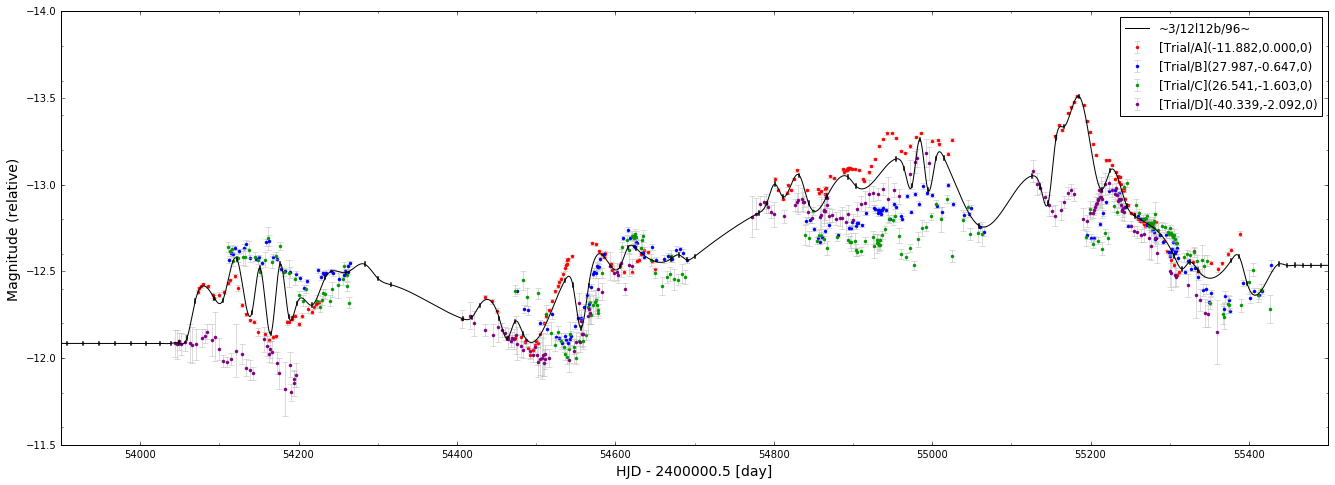

In [16]:
pycs.gen.lc.display(lcs, [spline], knotsize=0.01, figsize=(20, 7), jdrange=(53900, 55500))

## 3.2 Including Microlensing

Now let's factor in four independent polynomial curves to account for any microlensing in our light curves. 

In [17]:
pycs.gen.polyml.addtolc(lcs[1], nparams=2, autoseasonsgap=600.0)
pycs.gen.polyml.addtolc(lcs[2], nparams=3, autoseasonsgap=600.0)
pycs.gen.polyml.addtolc(lcs[3], nparams=3, autoseasonsgap=600.0)

Now, let's try the model optimization again. The result should be much better! 

In [18]:
spline = spl(lcs) 

Starting opt_rough on initial delays :
AB  +39.87 | AC  +38.42 | AD  -28.46 | BC   -1.45 | BD  -68.33 | CD  -66.88
Aiming at curves A.
Starting ML optimization ...
Working on the poly ML of [Trial/B](27.987,-0.647,0)|poly/2|
Working on the poly ML of [Trial/C](26.541,-1.603,0)|poly/3|
Working on the poly ML of [Trial/D](-40.339,-2.092,0)|poly/3|
Done !
First spline and ML opt done.
AB  +15.87 | AC  +24.42 | AD  -45.46 | BC   +8.55 | BD  -61.33 | CD  -69.88    (Iteration  1, r2 =  30181.0)
AB   -1.13 | AC   +3.42 | AD  -58.46 | BC   +4.55 | BD  -57.33 | CD  -61.88    (Iteration  2, r2 =  22541.0)
AB   -8.13 | AC  -12.58 | AD  -64.46 | BC   -4.45 | BD  -56.33 | CD  -51.88    (Iteration  3, r2 =  19645.8)
AB  -13.13 | AC  -21.58 | AD  -68.46 | BC   -8.45 | BD  -55.33 | CD  -46.88    (Iteration  4, r2 =  18551.8)
AB  -15.13 | AC  -26.58 | AD  -69.46 | BC  -11.45 | BD  -54.33 | CD  -42.88    (Iteration  5, r2 =  18256.0)
Rough time shifts done :
AB  -15.13 | AC  -26.58 | AD  -69.46 | BC  -1

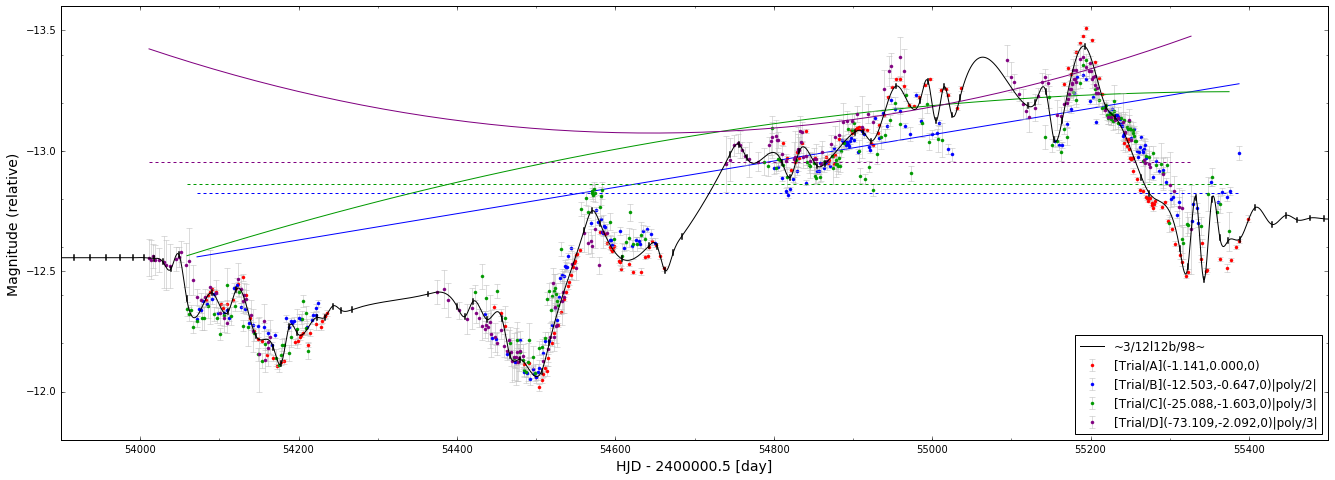

In [19]:
pycs.gen.lc.display(lcs, [spline], knotsize=0.01, figsize=(20, 7), jdrange=(53900, 55500))

The new time delays should show the difference once microlensing is factored in. We'll compare our previous time delay output to this output. 

In [20]:
polynomial_microlensing_time_delays = pycs.gen.lc.getnicetimedelays(lcs, separator="\n", sorted=True)
print("Time Delays (microlensing included, with polynomials):")
print(polynomial_microlensing_time_delays)

print("cf. Time Delays (no microlensing):")
print(basic_time_delays)

Time Delays (microlensing included, with polynomials):
AB  -11.36
AC  -23.95
AD  -71.97
BC  -12.58
BD  -60.61
CD  -48.02
cf. Time Delays (no microlensing):
AB  +39.87
AC  +38.42
AD  -28.46
BC   -1.45
BD  -68.33
CD  -66.88


## 3.3 Modeling Microlensing with Splines

If we add spline models for the microlensing, they displace the polynomial model:

In [21]:
pycs.gen.splml.addtolc(lcs[0], knotstep=150)
pycs.gen.splml.addtolc(lcs[1], knotstep=150)
pycs.gen.splml.addtolc(lcs[2], knotstep=150)
pycs.gen.splml.addtolc(lcs[3], knotstep=150)

I replace an existing mircolensing.
I replace an existing mircolensing.
I replace an existing mircolensing.


Let's re-optimize and see what happens to the time delays:

In [22]:
spline = spl(lcs)

Starting opt_rough on initial delays :
AB  -11.36 | AC  -23.95 | AD  -71.97 | BC  -12.58 | BD  -60.61 | CD  -48.02
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Trial/A](-1.141,0.000,0)|~3/u/7~|
Working on the spline ML of [Trial/B](-12.503,-0.647,0)|~3/u/7~|
Working on the spline ML of [Trial/C](-25.088,-1.603,0)|~3/u/7~|
Working on the spline ML of [Trial/D](-73.109,-2.092,0)|~3/u/7~|
Done !
First spline and ML opt done.
AB  -12.36 | AC  -23.95 | AD  -76.97 | BC  -11.58 | BD  -64.61 | CD  -53.02    (Iteration  1, r2 =   9231.6)
AB  -13.36 | AC  -23.95 | AD  -80.97 | BC  -10.58 | BD  -67.61 | CD  -57.02    (Iteration  2, r2 =   9162.3)
AB  -13.36 | AC  -23.95 | AD  -82.97 | BC  -10.58 | BD  -69.61 | CD  -59.02    (Iteration  3, r2 =   9141.6)
AB  -13.36 | AC  -23.95 | AD  -84.97 | BC  -10.58 | BD  -71.61 | CD  -61.02    (Iteration  4, r2 =   9128.9)
AB  -13.36 | AC  -23.95 | AD  -85.97 | BC  -10.58 | BD  -72.61 | CD  -62.02    (Iteration  5, r2 =   9

In [23]:
spline_microlensing_time_delays = pycs.gen.lc.getnicetimedelays(lcs, separator="\n", sorted=True)
print("Time Delays (microlensing included, with splines):")
print(spline_microlensing_time_delays)

print("cf. Time Delays (microlensing included, with polynomials):")
print(polynomial_microlensing_time_delays)

Time Delays (microlensing included, with splines):
AB   -4.80
AC  -20.66
AD  -68.62
BC  -15.86
BD  -63.81
CD  -47.95
cf. Time Delays (microlensing included, with polynomials):
AB  -11.36
AC  -23.95
AD  -71.97
BC  -12.58
BD  -60.61
CD  -48.02


We see differences, but the results from the two types of microlensing model are much closer together than either of them are with the time delays from the "no microlensing" model. 

What do these spline microlensing models look like?

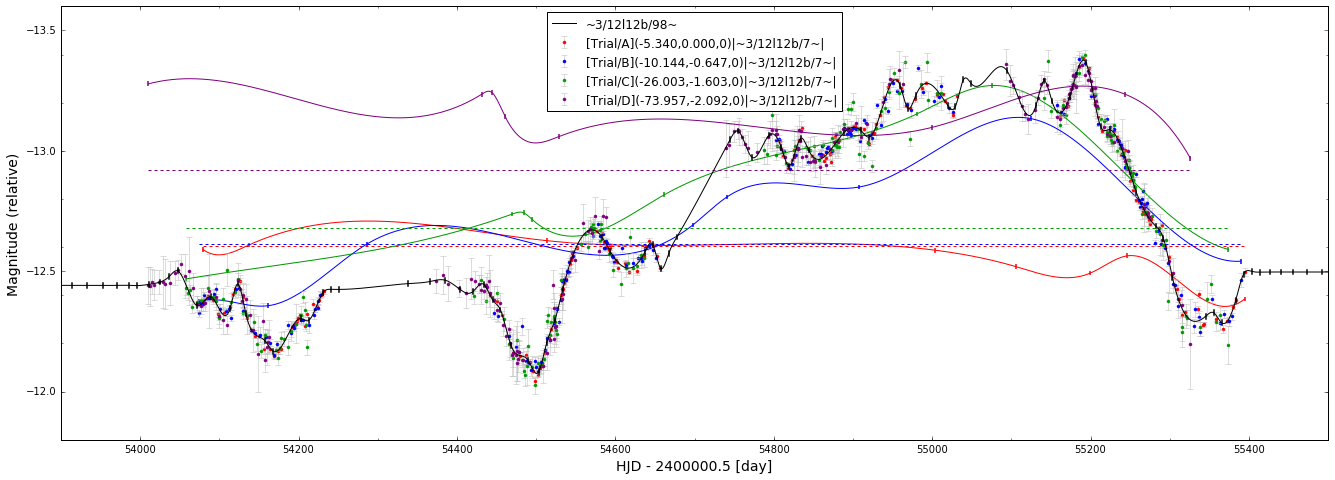

In [25]:
pycs.gen.lc.display(lcs, [spline], knotsize=0.01, figsize=(20, 7), jdrange=(53900, 55500))

Let's save this to a PDF figure:

In [26]:
pycs.gen.lc.display(lcs, [spline], knotsize=0.01, figsize=(20, 7), jdrange=(53900, 55500),filename="fig_modelfit.pdf")

Plot written to fig_modelfit.pdf


Now that we have a well-optimized model, lets save it and the shifted light curves to a pickle file that we can use later.

In [27]:
pycs.gen.util.writepickle((lcs, spline), "optspline.pkl")

Wrote optspline.pkl


## 4. Estimating the Time Delay Uncertanties

Error estimation with `PyCS` is performed by re-sampling the data, re-optimizing the model, and accumulating statistics about the resulting time delays. 

To evaluate the intrinsic variance of the optimizer, we make 200 copies of the dataset, and re-optimize the model for each one. To probe the width of the likelihood function itself, we generate and use 100 synthetic datasets, with slightly different time delays. For the latter step, we need to read in an optimized model and its shifted light curves.

First, the copies:

In [30]:
pycs.sim.draw.multidraw(lcs, onlycopy=True, n=5, npkl=4, simset="copies")

Now thowing dice into sims_copies ...
Input shifts :
A    -5.34 | B   -10.14 | C   -26.00 | D   -73.96
Input delays :
AB   -4.80 | AC  -20.66 | AD  -68.62 | BC  -15.86 | BD  -63.81 | CD  -47.95
Preparing 5 identical copies for pkl 1/4 ...
Wrote sims_copies/1_1466177112.59808.pkl
Preparing 5 identical copies for pkl 2/4 ...
Wrote sims_copies/2_1466177112.62152.pkl
Preparing 5 identical copies for pkl 3/4 ...
Wrote sims_copies/3_1466177112.65164.pkl
Preparing 5 identical copies for pkl 4/4 ...
Wrote sims_copies/4_1466177112.77888.pkl


Now the synthetic light curves:

In [28]:
(modellcs, modelspline)  = pycs.gen.util.readpickle("optspline.pkl")

Read optspline.pkl


We want each synthetic light curve to have slightly different underlying microlensing signals as well as a slightly different set of time delays. This is achieved via a set of "tweak" functions, that implement some small scale extrinsic variability when we generate the synthetic curves. Note that the control parameters `beta`, `sigma`, and `fmin` have to be *asserted*, these values can be changed. 

In [29]:
def Atweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.5, sigma=0.25, fmin=1/500.0, fmax=None, psplot=False)

def Btweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.0, sigma=0.9, fmin=1/500.0, fmax=None, psplot=False)

def Ctweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.0, sigma=1.5, fmin=1/500.0, fmax=None, psplot=False)

def Dtweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-0.0, sigma=4.5, fmin=1/500.0, fmax=None, psplot=False)

At this place, *only* if you know what you are doing, you can manually adjust the microlensing or the delays. If not, run this script. This will run 10 simulations for each element in the pickle file. 

In [31]:
pycs.sim.draw.saveresiduals(modellcs, modelspline)
pycs.sim.draw.multidraw(modellcs, modelspline, n=10, npkl=10, simset="1Kset1",
        truetsr=8.0, tweakml=[Atweakml, Btweakml, Ctweakml, Dtweakml])

Now thowing dice into sims_1Kset1 ...
Input shifts :
A    -5.34 | B   -10.14 | C   -26.00 | D   -73.96
Input delays :
AB   -4.80 | AC  -20.66 | AD  -68.62 | BC  -15.86 | BD  -63.81 | CD  -47.95
Drawing 10 simulations for pkl 1/10 ...


/Users/pjm/miniconda2/lib/python2.7/site-packages/pycs/gen/spl.py:342: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (self.t == None):


Wrote sims_1Kset1/1_1466177205.89002.pkl
Drawing 10 simulations for pkl 2/10 ...
Wrote sims_1Kset1/2_1466177206.45391.pkl
Drawing 10 simulations for pkl 3/10 ...
Wrote sims_1Kset1/3_1466177206.99310.pkl
Drawing 10 simulations for pkl 4/10 ...
Wrote sims_1Kset1/4_1466177207.51908.pkl
Drawing 10 simulations for pkl 5/10 ...
Wrote sims_1Kset1/5_1466177208.07940.pkl
Drawing 10 simulations for pkl 6/10 ...
Wrote sims_1Kset1/6_1466177208.60788.pkl
Drawing 10 simulations for pkl 7/10 ...
Wrote sims_1Kset1/7_1466177209.17143.pkl
Drawing 10 simulations for pkl 8/10 ...
Wrote sims_1Kset1/8_1466177209.72292.pkl
Drawing 10 simulations for pkl 9/10 ...
Wrote sims_1Kset1/9_1466177210.31131.pkl
Drawing 10 simulations for pkl 10/10 ...
Wrote sims_1Kset1/10_1466177210.88425.pkl


Note that we chose the name of our set of synthetic light curves "1Kset1" via the `simset` kwarg. "truetsr=8.0" means that the synthetic curves will get random true time shifts in a range of about 8.0 days around the time shifts of the model `lcs` objects. 

## 5. Running Curve-Shifting Methods with Different Techniques 

Have it include the error; commit with the error, scroll down to this script 6; this line doesn't work, put in error message, explain, report on what i will do with the rest; comment out everything htat needs free-spline; this is a bug in PyCS tutorial that we should report --> paste the scripts in; 

We are now going to run three curve-shifting methods on these data sets. To "define" the microlensing models and initial shifts, we make use of one single set of curves, the observed data. 

Let's set some reasonable guess delays. We can obtain these by eye or through the model fit. 

In [ ]:
lcs[1].shifttime(-7.0)
lcs[2].shifttime(-22.0)
lcs[3].shifttime(-65.0)

Our first technique will be the free-knot spline technique. First, we will define the microlensing model, like in Step 3. 

In [ ]:
pycs.gen.splml.addtolc(lcs[0], knotstep=150)
pycs.gen.splml.addtolc(lcs[1], knotstep=150)
pycs.gen.splml.addtolc(lcs[2], knotstep=150)
pycs.gen.splml.addtolc(lcs[3], knotstep=150)

Now, we will run the free-knot spline technique using the plain copies we made earlier of the data. 

pycs.sim.run.multirun("copies", lcs, spl, optset="spl", tsrand=10.0, keepopt=True)

Now, we will run the free-knot spline technique using the copies of the synthetic light curve sets we made earlier.

In [ ]:
pycs.sim.run.multirun("1Kset1", lcs, spl, optset="spl", tsrand=10.0, keepopt=True)

**Note**: The two lines of code above do not run. This is bug that should be reported to PyCS through an issue on GitHub. Here is the resulting error message. 

`RuntimeError: Knot spacing min = 7.283257, epsilon = 10.000000`

**Note**: When you run this multirun, as shown above, keep `keepopt=True` as shown above. This will make it easier to read the residuals from the synthetic curves with the residuals from the observed data. You can change the name "optset" to anything, though it should reflect the full method, including the settings of the microlensing. 


Our second technique will be the dispersion technique. First, let's run the code needed to define our variables. 

In [ ]:
rawdispersionmethod = lambda lc1, lc2 : pycs.disp.disps.linintnp(lc1, lc2, interpdist = 30.0)
dispersionmethod = lambda lc1, lc2 : pycs.disp.disps.symmetrize(lc1, lc2, rawdispersionmethod)
def disp(lcs):
    return pycs.disp.topopt.opt_full(lcs, rawdispersionmethod, nit=5, verbose=True)

Next, let's factor in our microlensing models (polynomials). 

In [ ]:
pycs.gen.polyml.addtolc(lcs[0], nparams=2, autoseasonsgap = 60.0)
pycs.gen.polyml.addtolc(lcs[1], nparams=2, autoseasonsgap = 60.0)
pycs.gen.polyml.addtolc(lcs[2], nparams=2, autoseasonsgap = 60.0)
pycs.gen.polyml.addtolc(lcs[3], nparams=2, autoseasonsgap = 60.0)

Now we will run it using the dispersion technique on our plain copies data, created earlier. 

In [ ]:
pycs.sim.run.multirun("copies", lcs, disp, optset="disp", tsrand=10.0)

Now we will run it using the dispersion technique on our synthetic light curve data. 

In [ ]:
pycs.sim.run.multirun("1Kset1", lcs, disp, optset="disp", tsrand=10.0)

Finally, we will use our third technique, the regression difference technique. Let's define our variables. Remember, this line needs pymc to work. 

In [ ]:
def regdiff(lcs):
   return pycs.regdiff.multiopt.opt_ts(lcs, pd=5, scale=200.0, verbose=True)

Now we will run it using the regression difference technique on our plain copies data, created earlier. 

In [ ]:
pycs.sim.run.multirun("copies", lcs, regdiff, optset="regdiff", tsrand=10.0)

Now we will run it using the regression difference technique on our synthetic light curve data. 

In [ ]:
pycs.sim.run.multirun("1Kset1", lcs, regdiff, optset="regdiff", tsrand=10.0)

## 6. Reading the Results from the Observed Light Curves

This script will read the results from the copies of the observed light curves. 

In [ ]:
dataresults = [
        pycs.sim.run.collect("sims_copies_opt_disp", "red", "Dispersion-like technique"),
        pycs.sim.run.collect("sims_copies_opt_regdiff", "green", "Regression difference technique")
]

Now, we can turn this into a simple histogram that will give the instrinic variance. It will be saved to a file called "fig_instrinsicvariance.pdf", for readability. The option `dataout=True` will save the delay point estimate, to be used below. 

In [ ]:
pycs.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False,
        filename="fig_intrinsicvariance.pdf", dataout=True)

We read the results obtained on the synthetic curves. 

In [ ]:
simresults = [
        pycs.sim.run.collect("sims_1Kset1_opt_disp", "red", "Dispersion-like technique"),
        pycs.sim.run.collect("sims_1Kset1_opt_regdiff", "green", "Regression difference technique")
]

Now we can perform the error analysis. This will be saved to a file called "fig_measvstrue.pdf". The option dataout=True will save the random and systematic error, to be used below.

In [ ]:
pycs.sim.plot.measvstrue(simresults, errorrange=3.5, r=5.0, nbins = 10, binclip=True, binclipr=20.0,
        plotpoints=False, filename="fig_measvstrue.pdf", dataout=True)

With the same data we can also show the relationship between measurements. This will be written to a file called "fig_covplot.pdf".

In [ ]:
pycs.sim.plot.covplot(simresults, filename="fig_covplot.pdf")

Finally we group the information saved by these steps to get the results in form of a summary plot. Let's define our variables. 

In [ ]:
disp = (pycs.gen.util.readpickle("sims_copies_opt_disp_delays.pkl"),
        pycs.gen.util.readpickle("sims_1Kset1_opt_disp_errorbars.pkl"))

regdiff = (pycs.gen.util.readpickle("sims_copies_opt_regdiff_delays.pkl"),
        pycs.gen.util.readpickle("sims_1Kset1_opt_regdiff_errorbars.pkl"))

# spl = (pycs.gen.util.readpickle("sims_copies_opt_spl_delays.pkl"),
#        pycs.gen.util.readpickle("sims_1Kset1_opt_spl_errorbars.pkl"))

Now we can display our plot! It will be saved to a file called "fig_delays.pdf".

In [ ]:
pycs.sim.plot.newdelayplot([disp, regdiff, spl], rplot=6.0, displaytext=True,
        filename = "fig_delays.pdf", refshifts=[{"colour":"gray", "shifts":(0, -5, -20, -70)}])